## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import the necessary packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Step 1: Camera Calibration

In [2]:
def cameraCalibration(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = cameraCalibration(images)

## Step 2: Apply a distortion correction to raw images

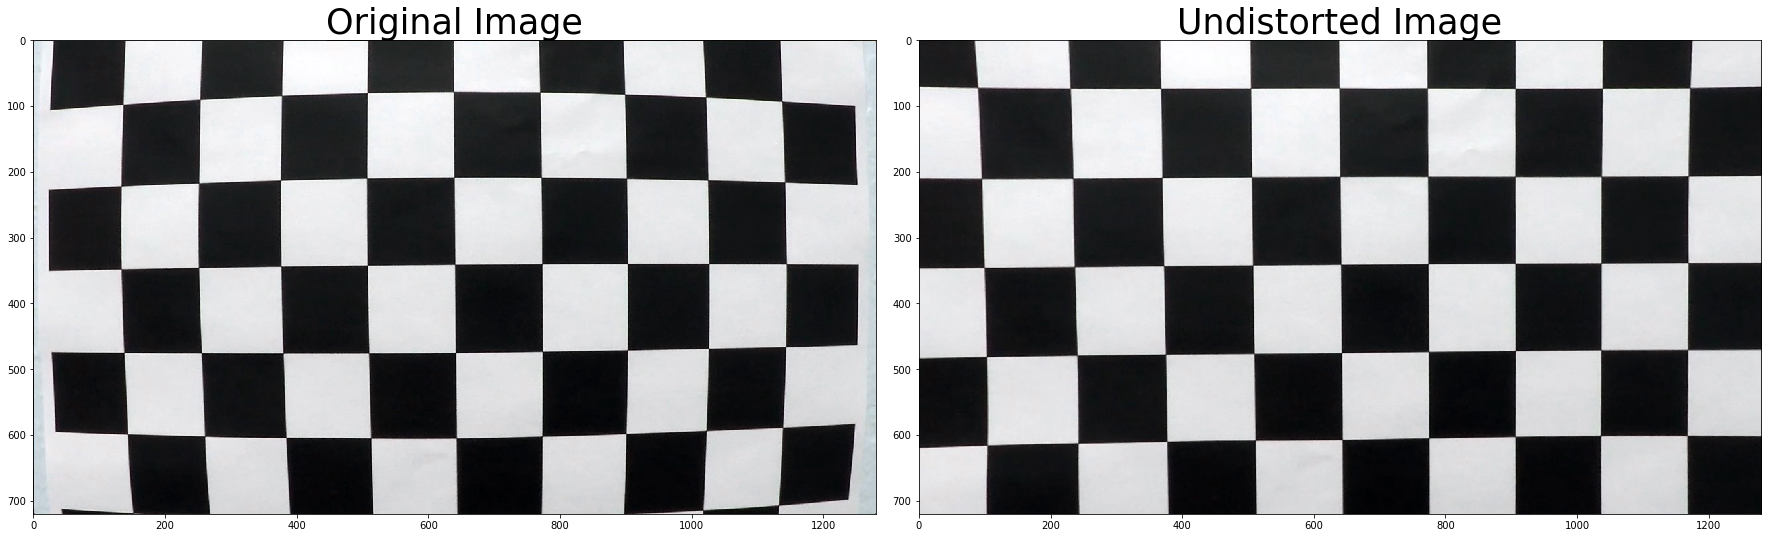

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

def plot_result(img_1,title_1,img_2,title_2):
    # plot the undistorted image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_1)
    ax1.set_title(title_1, fontsize=35)
    ax2.imshow(img_2, cmap = 'gray')
    ax2.set_title(title_2, fontsize=35)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plot_result(img,'Original Image',dst,'Undistorted Image')

## Step 3: Use color transforms, gradients, etc., to create a thresholded binary image

In [4]:
# load a test image and undistort it
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)

### 3.1 Absolute sobel gradient threshold

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

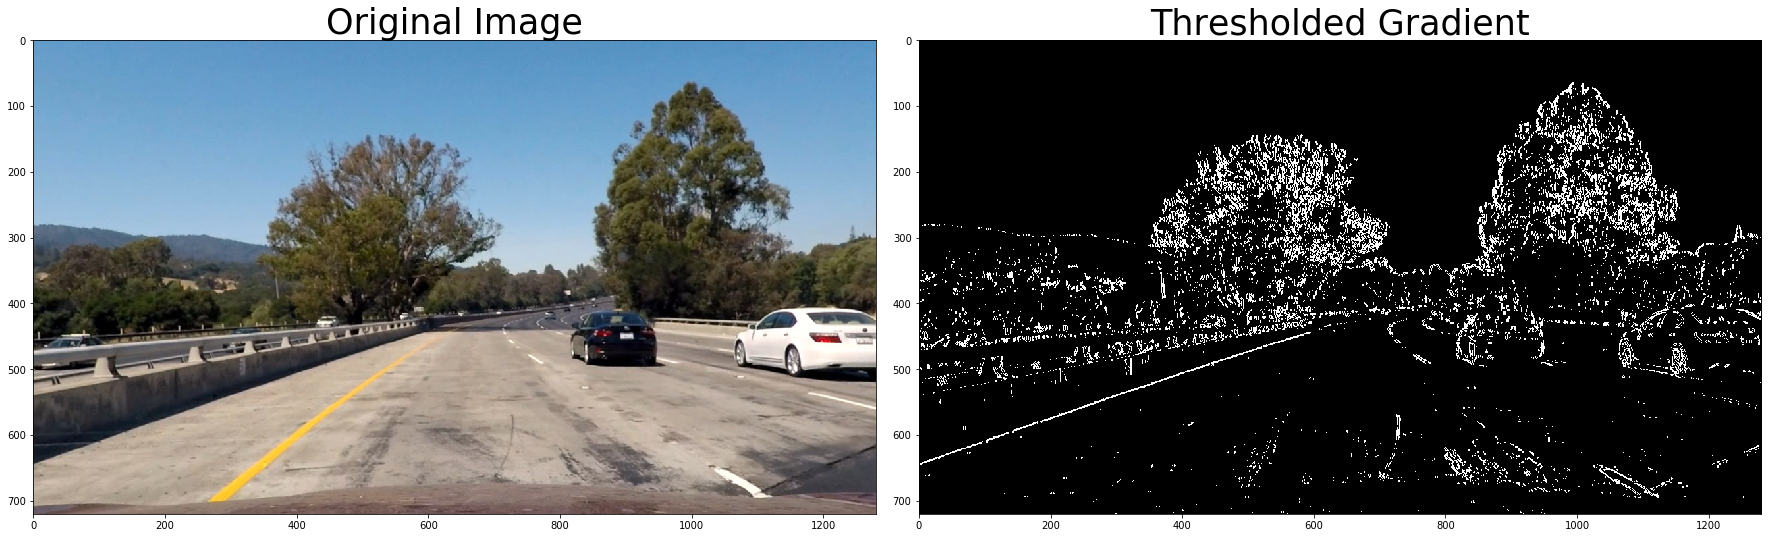

In [6]:
# run the function and draw the figures under certain threshold
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=80)
plot_result(img,'Original Image',grad_binary,'Thresholded Gradient')

### 3.2 Magnitude of Gradient Threshold

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

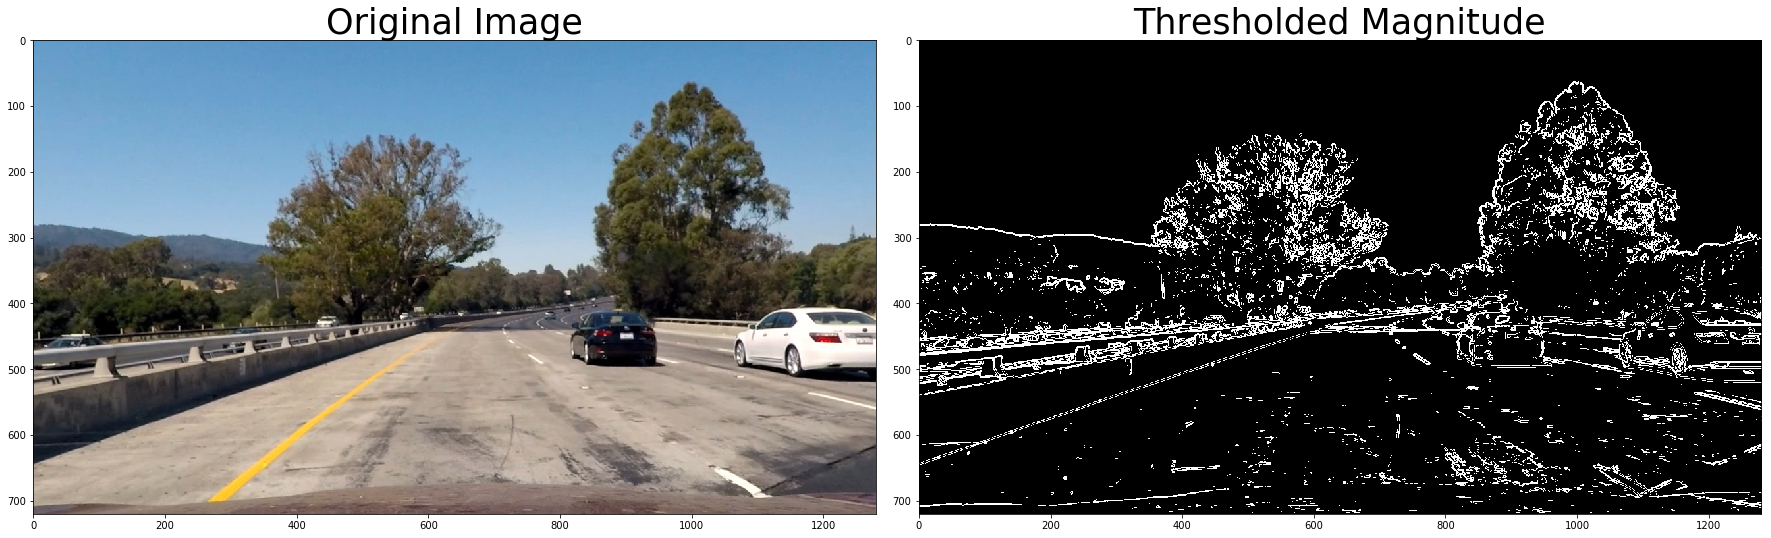

In [8]:
# run the function and draw the figures under certain threshold
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
plot_result(img,'Original Image',mag_binary,'Thresholded Magnitude')


### 3.3 Direction of Gradient Threshold

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize = sobel_kernel))
    
    #Calculate the direction of the gradient 
    direction = np.arctan2(sobely, sobelx)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

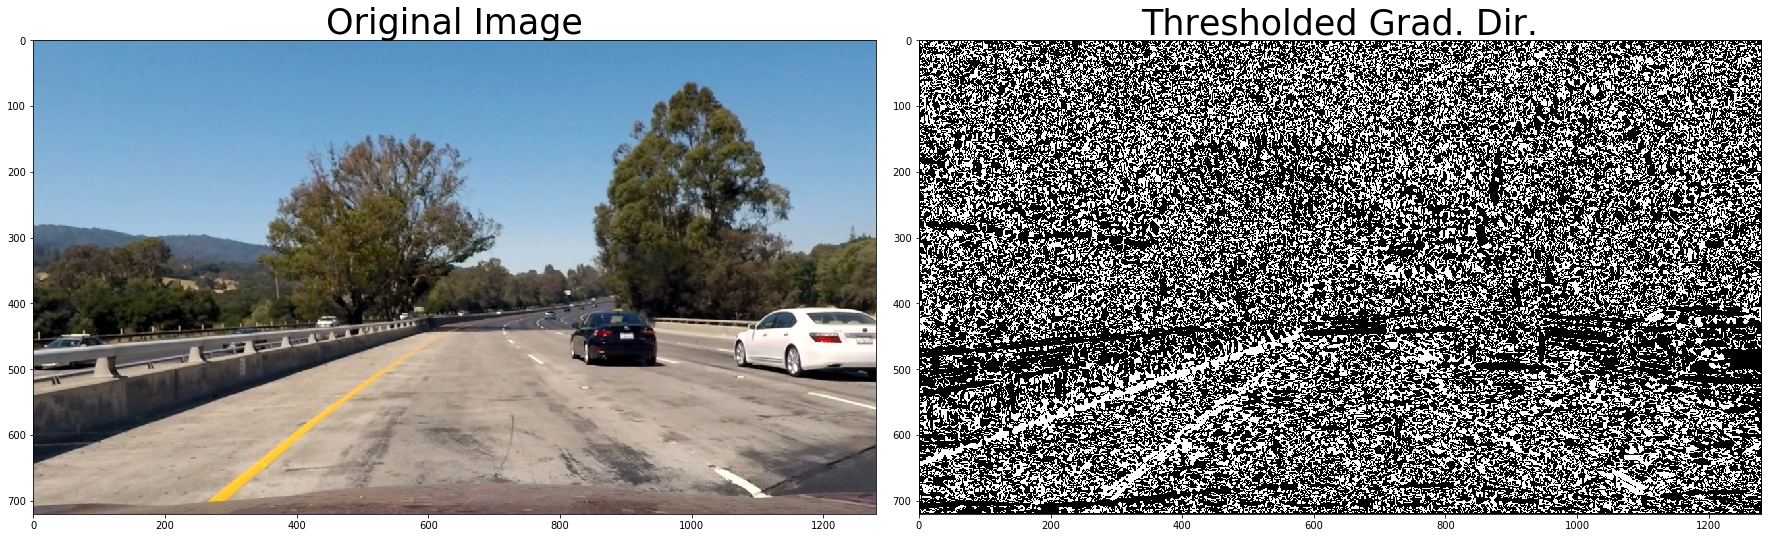

In [10]:
# run the function and draw the figures under certain threshold
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plot_result(img,'Original Image',dir_binary,'Thresholded Grad. Dir.')

### 3.4 HLS and Color Thresholds

In [11]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


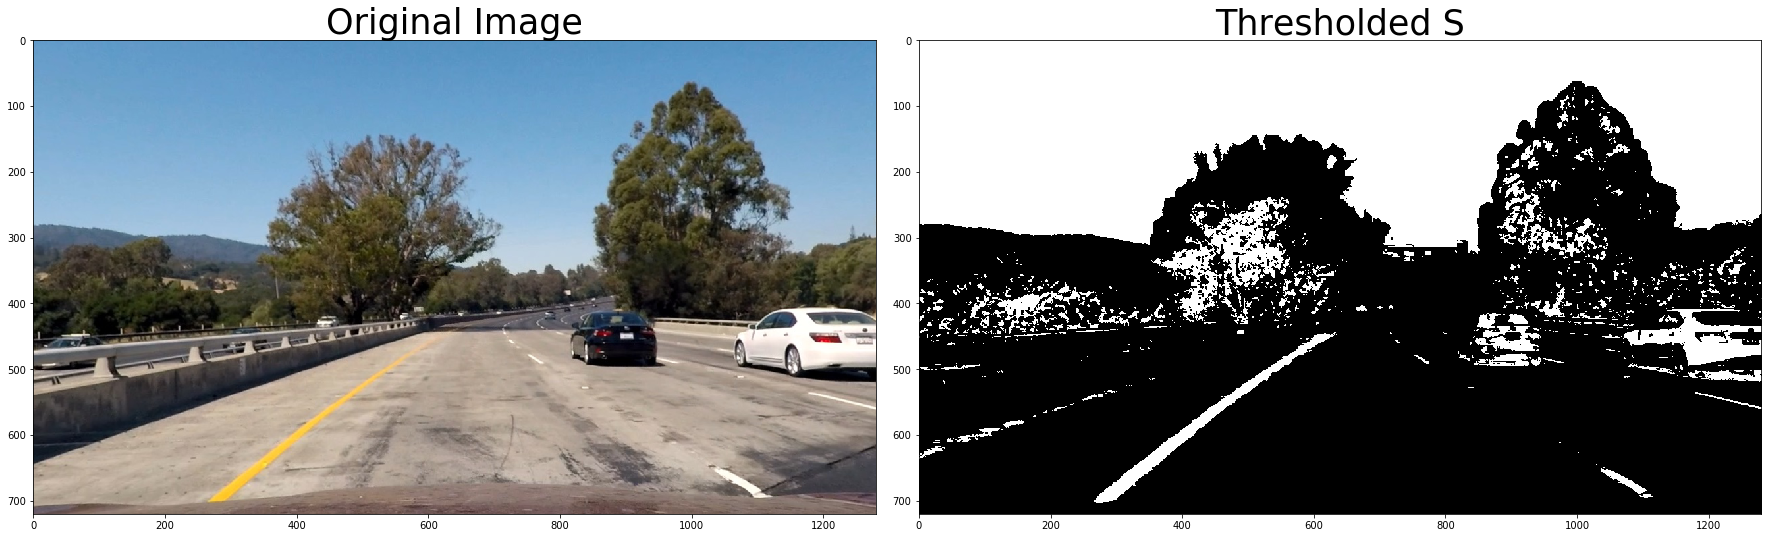

In [12]:
# run the function and draw the figures under certain threshold
hls_binary = hls_select(img, thresh=(90, 255))
plot_result(img,'Original Image',hls_binary,'Thresholded S')

### 3.5 Combine All The Previous Thresholds

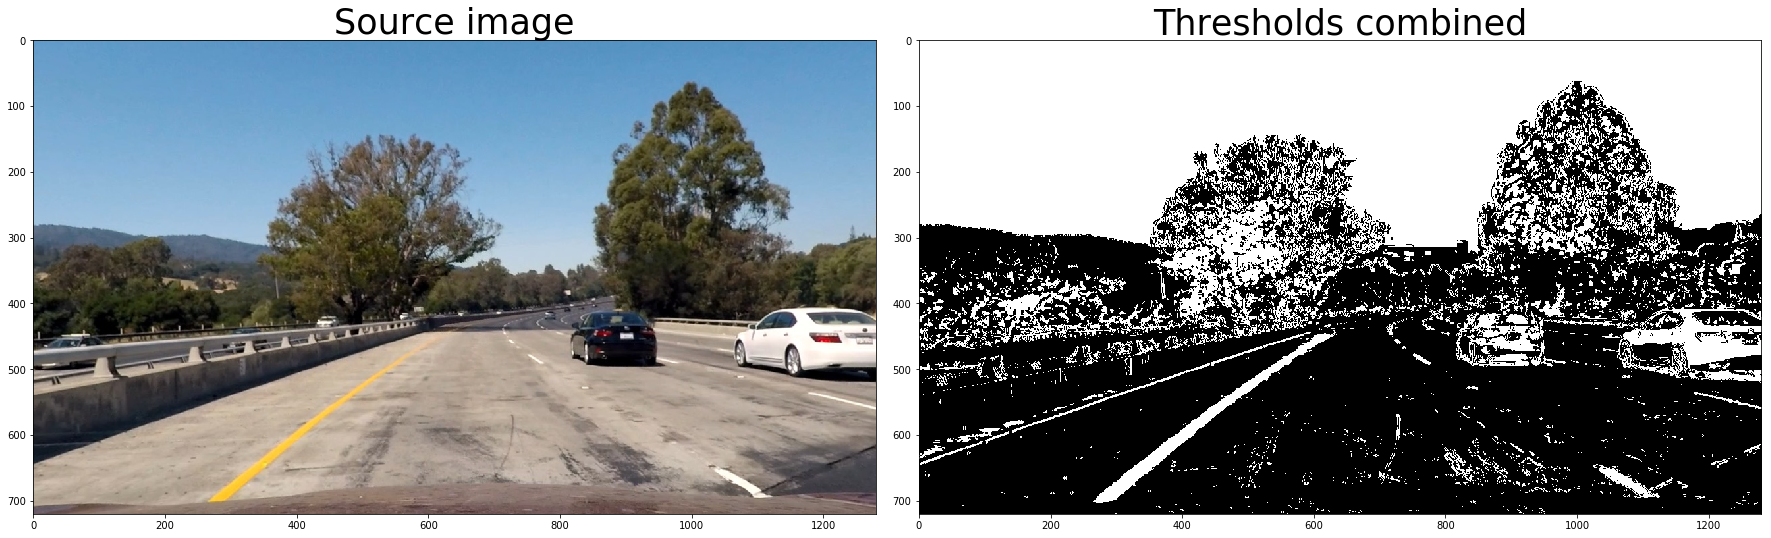

In [13]:
def combined_threshold(grad_binary,mag_binary,dir_binary,hls_binary):
    combined = np.zeros_like(grad_binary)
    combined[(grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    return combined
# Run the function
combined = combined_threshold(grad_binary,mag_binary,dir_binary,hls_binary)
# Plot the result
plot_result(img, 'Source image', combined, 'Thresholds combined')

## Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").

In [14]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img,mtx, dist):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[220,700], #bottom left
                      [1180,700],#bottom right
                      [750,460],         #top right
                      [590,460]])        #top left
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[220,720],  #bottom left
                      [1180,720], #bottom right
                      [1180,0],   #top right
                      [200,0]])   #top left
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Given src and dst points, calculate the inverse perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


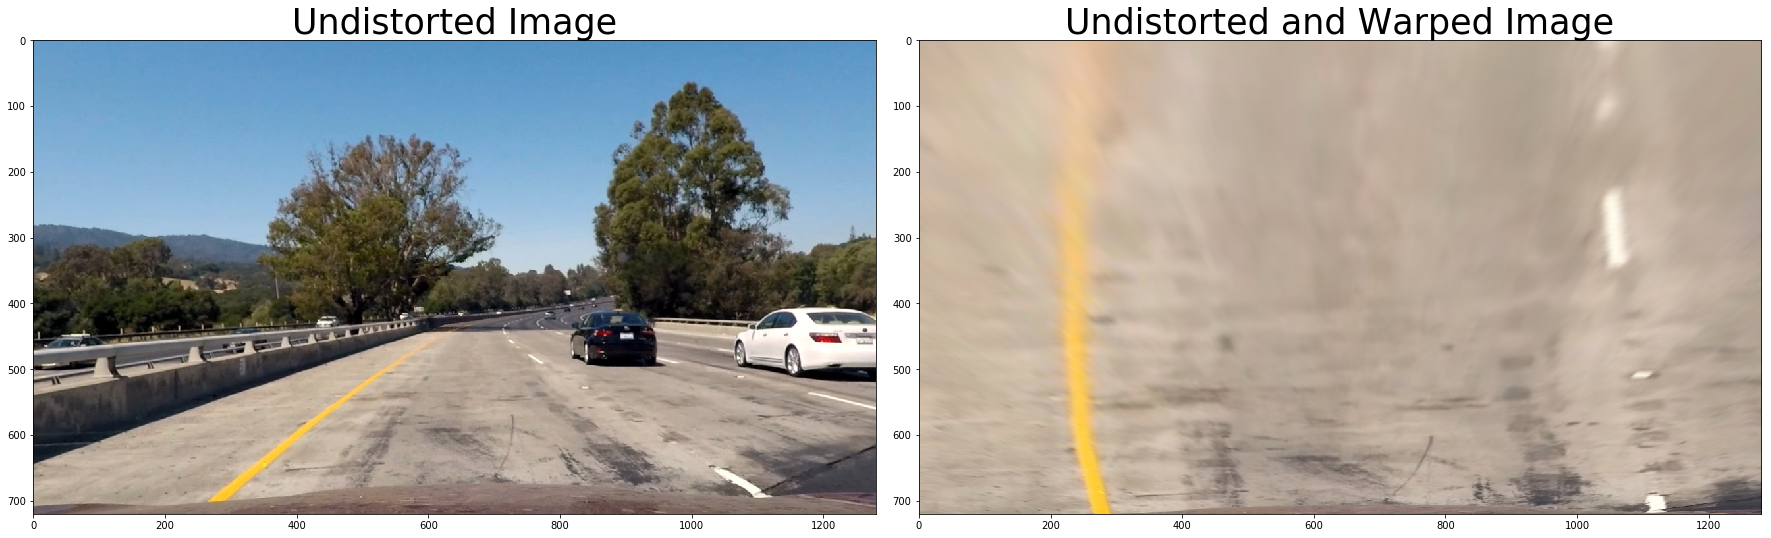

In [15]:
# Run the function and plot results
warped, M, Minv = corners_unwarp(img,mtx, dist)
plot_result(img,'Undistorted Image',warped,'Undistorted and Warped Image')

## Step 5: Detect lane pixels and fit to find the lane boundary.

### 5.1 Locate Lane Lines with Histogram

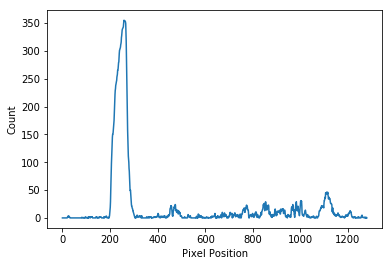

In [16]:
binary_warped, perspective_M, perspective_Minv = corners_unwarp(combined, mtx, dist)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# plot the histogram of the botoom halp image
plt.xlabel('Pixel Position')
plt.ylabel('Count')
plt.plot(histogram)

### 5.2 Implement Sliding Windows and Fit a Polynomial

[  1.02743334e-04  -4.48641240e-02   2.42036214e+02]
[  1.49735631e-04   1.65048347e-02   1.03781534e+03]


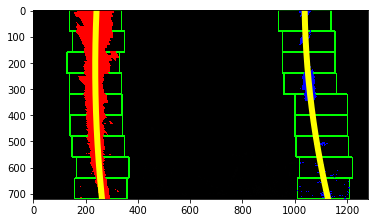

In [17]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 3) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
              
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow', LineWidth='6')
    plt.plot(right_fitx, ploty, color='yellow', LineWidth='6')

    return left_fit, right_fit, out_img


left_fit, right_fit,out_img = fit_polynomial(binary_warped)
print(left_fit)
print(right_fit)
plt.imshow(out_img)

In [18]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
#     left_fit = np.array([  1.02743334e-04,  -4.48641240e-02,   2.42036214e+02])
#     right_fit = np.array([  1.49735631e-04,   1.65048347e-02,   1.03781534e+03])
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow', LineWidth='6')
    plt.plot(right_fitx, ploty, color='yellow', LineWidth='6')
    ## End visualization steps ##
    
    return result,left_fitx, right_fitx, ploty

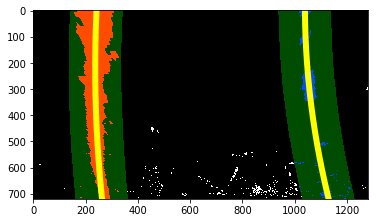

In [19]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit)

# View your output
plt.imshow(result)

## Step 6: Determine the curvature of the lane and vehicle position with respect to center.

In [20]:
def measure_curvature_pixels(ploty, leftx, rightx):
     # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [21]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fitx, right_fitx)

print('Left Lane Line Curvature: ',left_curverad, 'm')
print('Left Lane Line Curvature: ', right_curverad, 'm')

Left Lane Line Curvature:  1588.98635002 m
Left Lane Line Curvature:  990.897161181 m


### calculate the offset to the center of the image

In [37]:
def offset(left_fitx, right_fitx, img):
    road = (left_fitx[-1] + right_fitx[-1])/2
    car = img.shape[1] / 2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    return (car - road) * xm_per_pix

In [38]:
offsetx = offset(left_fitx, right_fitx, img)
print('The car offset from center is:', offsetx, 'm')

The car offset from center is: -0.296561943298 m


## Step 7: Warp the detected lane boundaries back onto the original image.

In [24]:
def warp(binary_warped, left_fitx, right_fitx, ploty, Minv, img):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

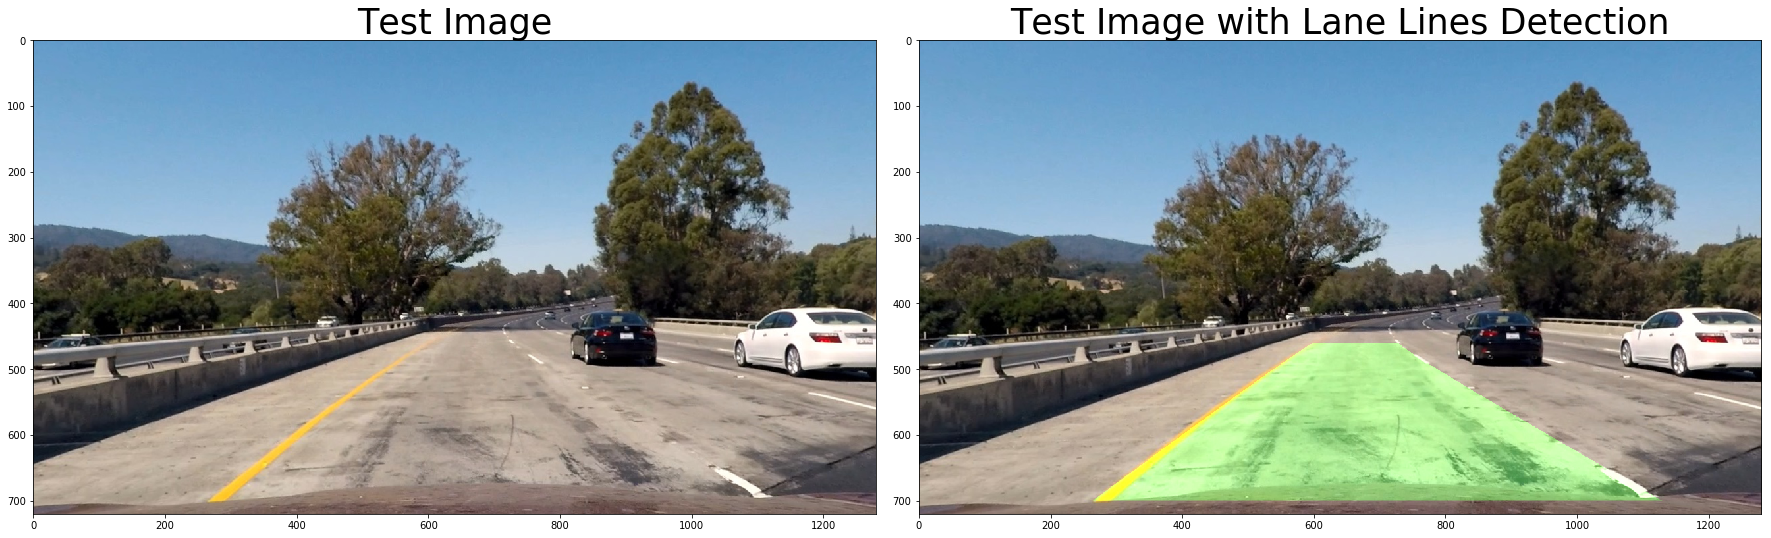

In [25]:
lane_lines = warp(binary_warped, left_fitx, right_fitx, ploty, Minv, img)
plot_result(img,'Test Image',lane_lines,'Test Image with Lane Lines Detection')

## Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [26]:
def display_parameters(img, ploty, left_fitx, right_fitx):
    # calculate the curvature and horizontal offset
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fitx, right_fitx)
    offsetx = offset(left_fitx, right_fitx, img)
    # display the parameters on the graph
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (200, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (200, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 5)
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (200, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 5)
    return out_img

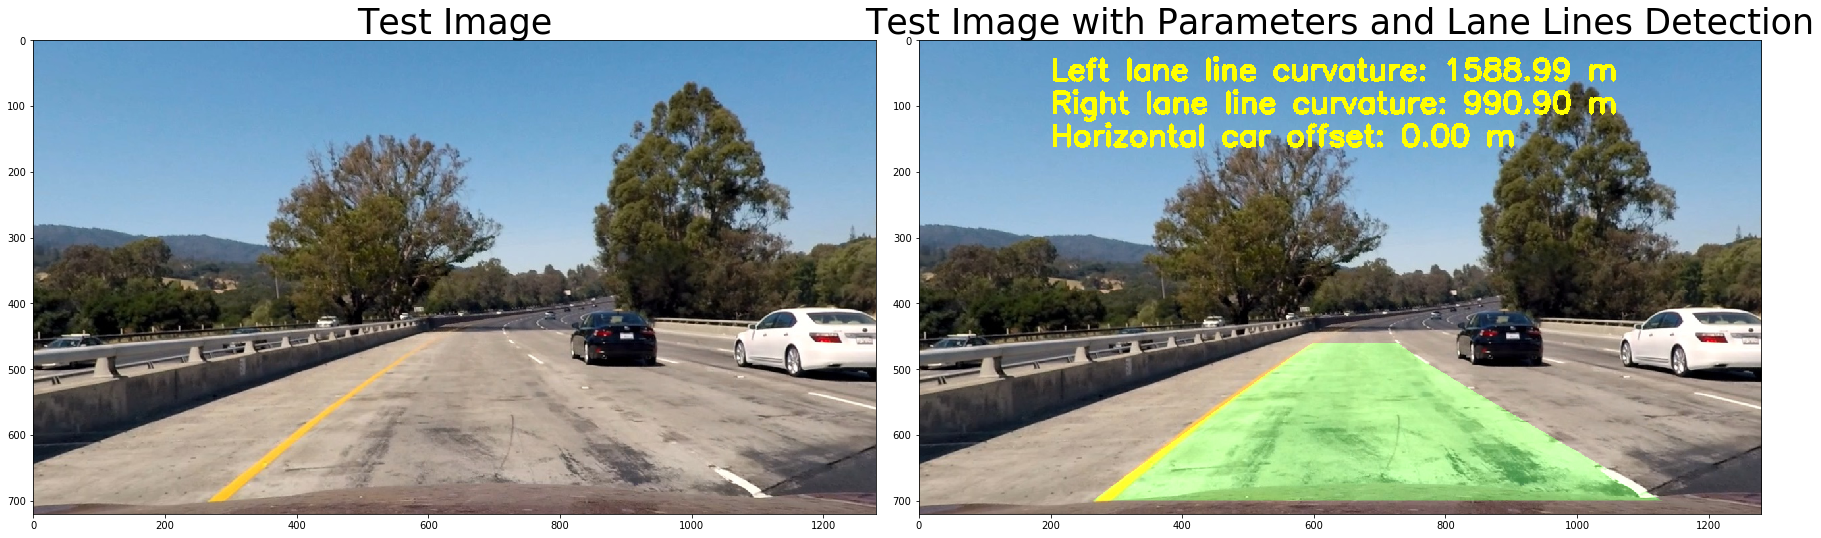

In [27]:
out_img = display_parameters(lane_lines,ploty, left_fitx, right_fitx)
plot_result(img,'Test Image',out_img,'Test Image with Parameters and Lane Lines Detection')

## Step 9: Test The Pipeline in A Video

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
class process_image:
    def __int__(self):
        # calibrate the camera
        images = glob.glob('./camera_cal/calibration*.jpg')
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cameraCalibration(images)
    def __call__(self,img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient threshold
        grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=80)

        # Calculate gradient magnitude threshold
        mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))

        # Calculate gradient direction threshold
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        hls_binary = hls_select(img, thresh=(90, 255))

        # Combine all the thresholds to identify the lane lines
        combined = combined_threshold(grad_binary,mag_binary,dir_binary,hls_binary)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        binary_warped, perspective_M, perspective_Minv = corners_unwarp(combined, mtx, dist)
                
        self.left_fit, self.right_fit,out_img = fit_polynomial(binary_warped)
        result, self.left_fitx, self.right_fitx, ploty = search_around_poly(binary_warped, self.left_fit, self.right_fit)
#         # Calculate the radius of curvature in pixels for both lane lines
#         left_curverad, right_curverad = measure_curvature_pixels(ploty, self.left_fitx, self.right_fitx)
        
        # Warp the detected lane boundaries back onto the original image.
        lane_lines = warp(binary_warped, self.left_fitx, self.right_fitx, ploty, perspective_Minv, img)
            
        # Add metrics to the output img
        out_img = display_parameters(lane_lines,ploty, self.left_fitx, self.right_fitx)
            
        return out_img

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4


100%|█████████▉| 1260/1261 [07:44<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

CPU times: user 5min 9s, sys: 30.8 s, total: 5min 40s
Wall time: 7min 47s


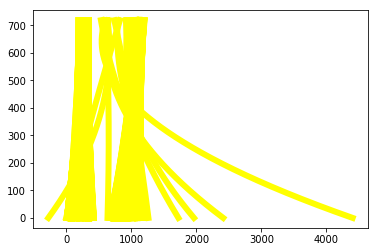

In [40]:
white_output = './project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
processImage = process_image()
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)